In [196]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import numpy as np

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.linear_model import LogisticRegression
from typing import List
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, classification_report

## Loading data

In [151]:
df = pd.read_csv("./data/winequalityN.csv")

## First look at data

In [152]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [153]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_1619/3360605439.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax)


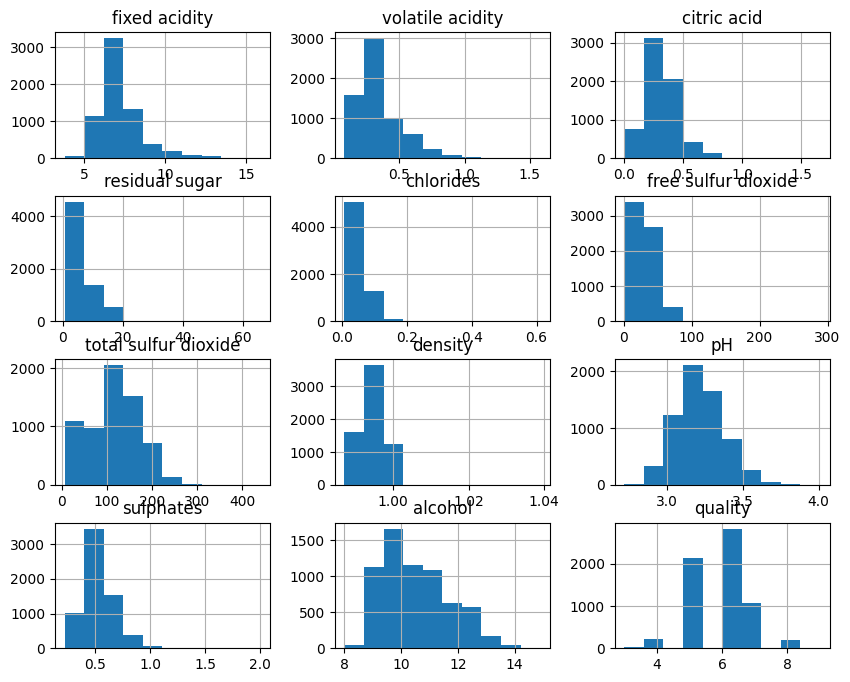

In [154]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
df.hist(ax = ax)
plt.show()

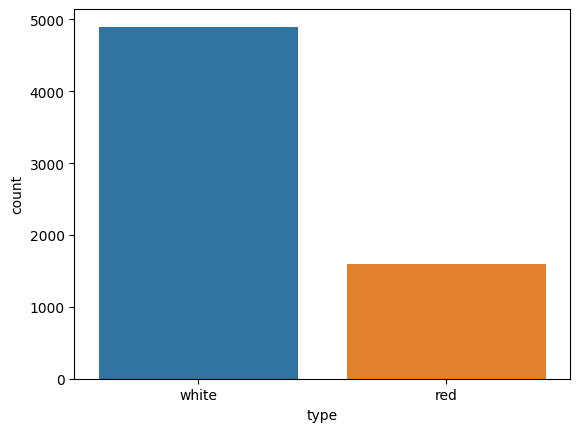

In [155]:
sns.countplot(x="type",data=df)
plt.show()

## Filling null values

In [156]:
df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [157]:
df["sulphates"].fillna(df.sulphates.mean(), inplace=True)
df.dropna(subset=["fixed acidity", "volatile acidity", "pH"], inplace=True)
df["citric acid"].fillna(df["citric acid"].mean(), inplace=True)
df["residual sugar"].fillna(df["residual sugar"].mean(), inplace=True)
df["chlorides"].fillna(df["chlorides"].mean(), inplace=True)

## Engineering is_white_wine feature

In [158]:
df["is_white_wine"] = df["type"] == "white"
df["is_white_wine"] = df["is_white_wine"].astype(int)

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_1619/2491725.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


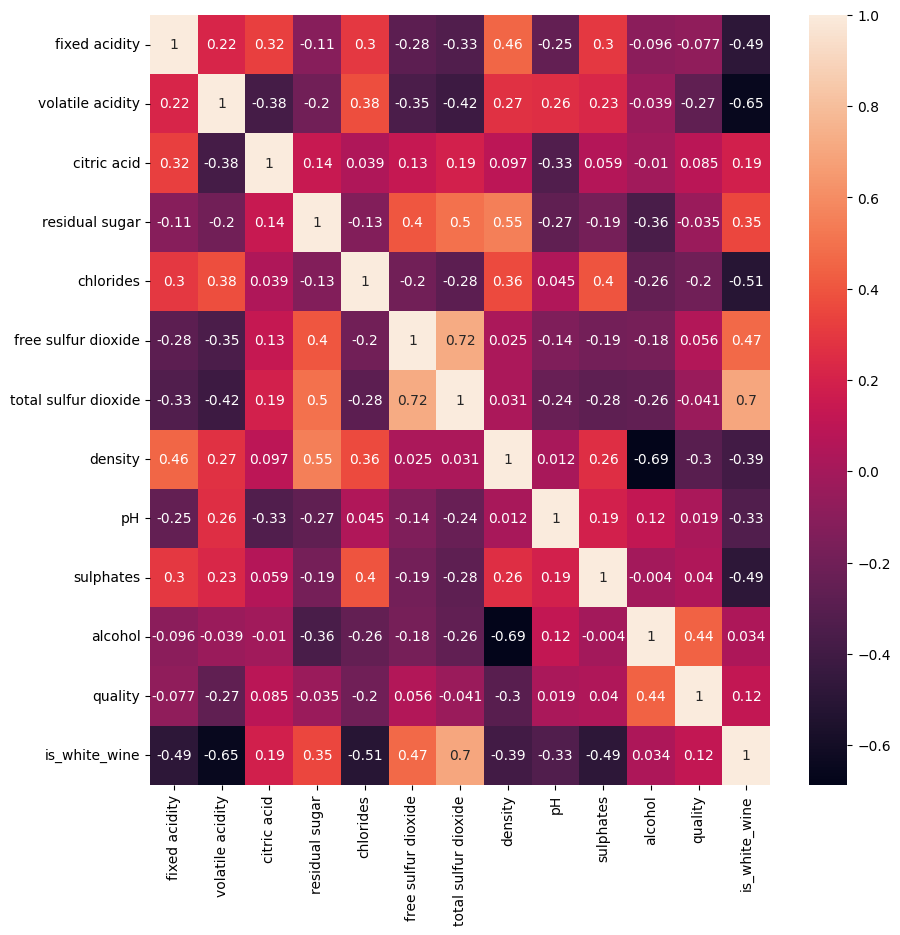

In [159]:
plt.figure(figsize=(10, 10))
corr = df.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

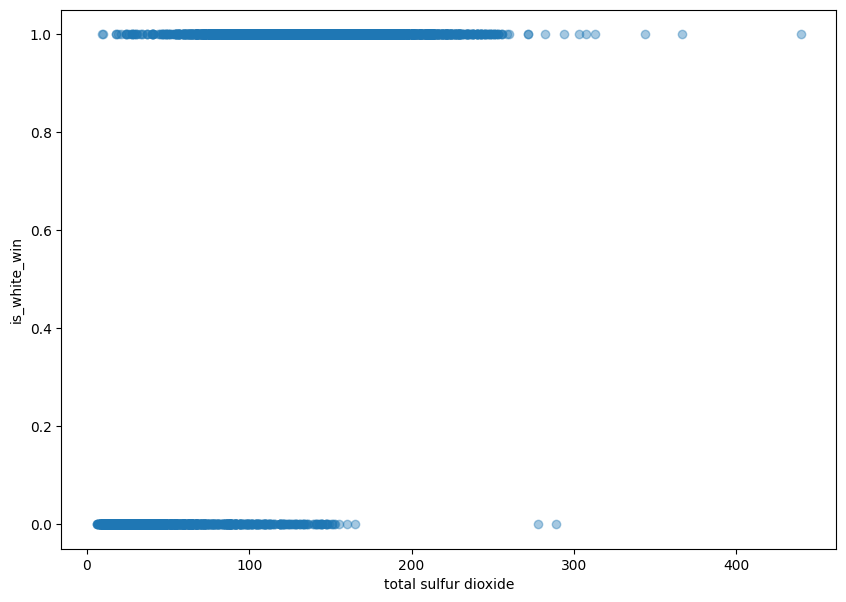

In [160]:
plt.figure(figsize=(10, 7))
plt.scatter(x="total sulfur dioxide", y="is_white_wine", data=df, alpha=0.4)
plt.xlabel("total sulfur dioxide")
plt.ylabel("is_white_win")
plt.show()

## Removing outliers

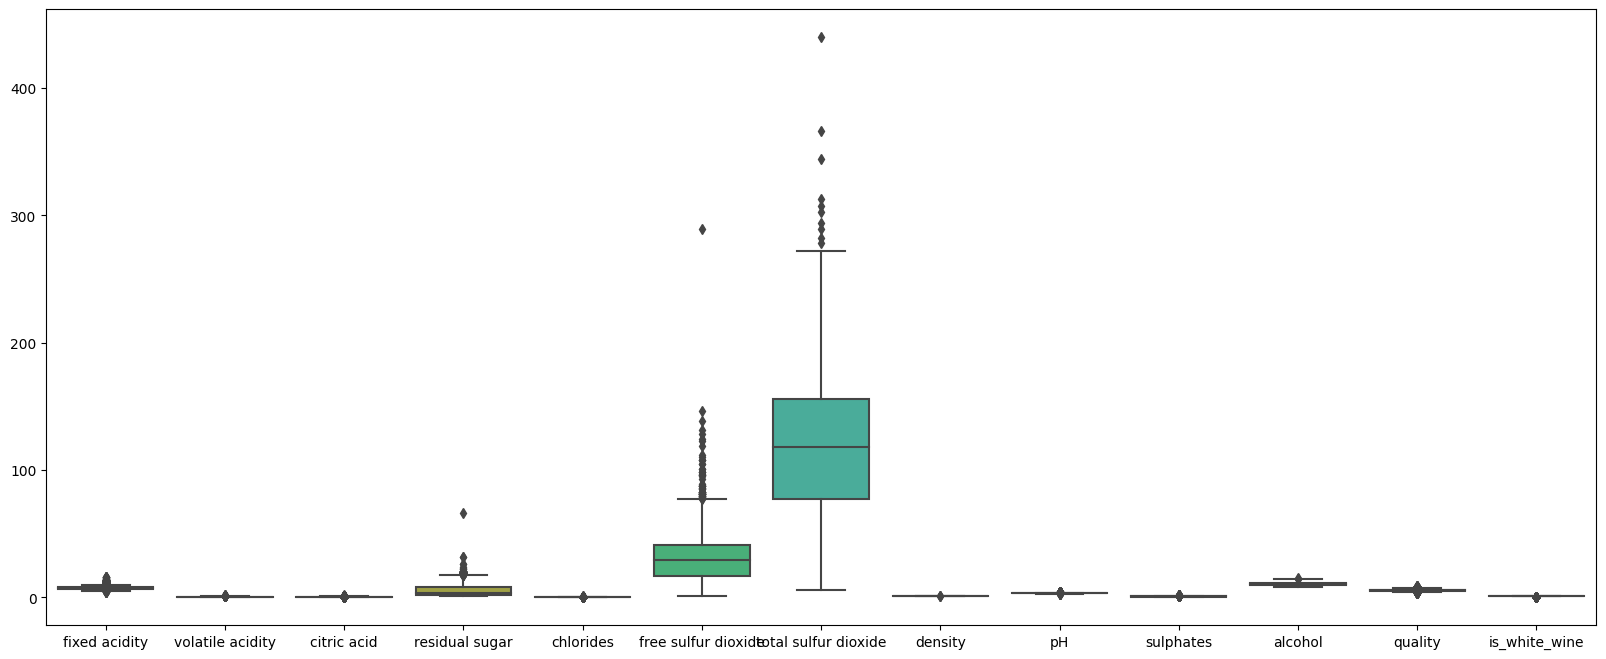

In [161]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=df)
plt.show()

In [162]:
lower_limit = df["free sulfur dioxide"].mean() - 3 * df["free sulfur dioxide"].std()
upper_limit = df["free sulfur dioxide"].mean() + 3 * df["free sulfur dioxide"].std()
print(lower_limit, upper_limit)

df = df[(df["free sulfur dioxide"] > lower_limit) & (df["free sulfur dioxide"] < upper_limit)]

-22.759452714286393 83.81614976356802


In [163]:
lower_limit = df["total sulfur dioxide"].mean() - 3 * df["total sulfur dioxide"].std()
upper_limit = df["total sulfur dioxide"].mean() + 3 * df["total sulfur dioxide"].std()
print(lower_limit, upper_limit)

df = df[(df["total sulfur dioxide"] > lower_limit) & (df["total sulfur dioxide"] < upper_limit)]

-53.24128937787839 283.6615161916115


In [164]:
lower_limit = df["residual sugar"].mean() - 3 * df["residual sugar"].std()
upper_limit = df["residual sugar"].mean() + 3 * df["residual sugar"].std()
print(lower_limit, upper_limit)

df = df[(df["residual sugar"] > lower_limit) & (df["residual sugar"] < upper_limit)]

-8.829063264852358 19.706298760031387


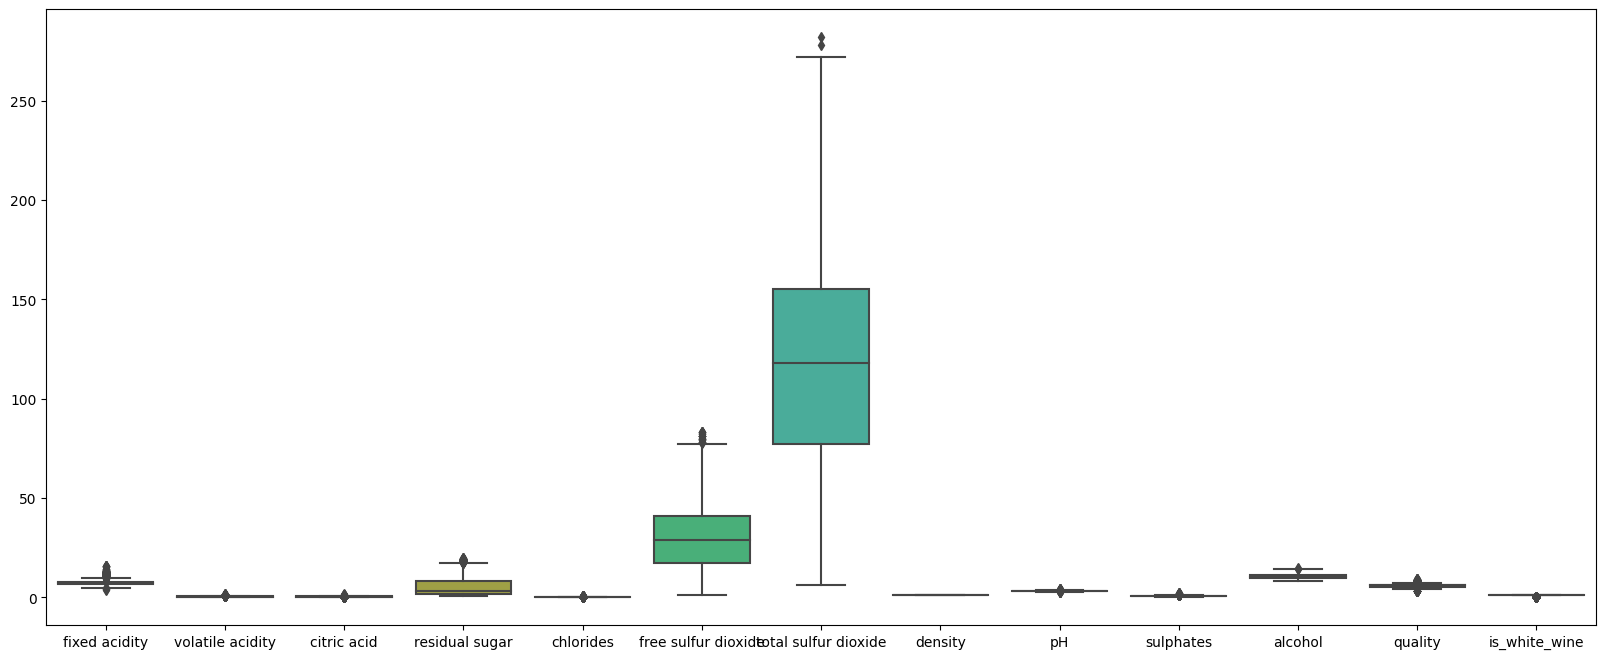

In [165]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=df)
plt.show()

## Remove duplicates

In [166]:
print("Shape before dropping duplicates: ", df.shape)
df.drop_duplicates(inplace=True)
print("Shape after dropping duplicates: ", df.shape)

Shape before dropping duplicates:  (6406, 14)
Shape after dropping duplicates:  (5254, 14)


## Standardising data

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_1619/3476585740.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax)


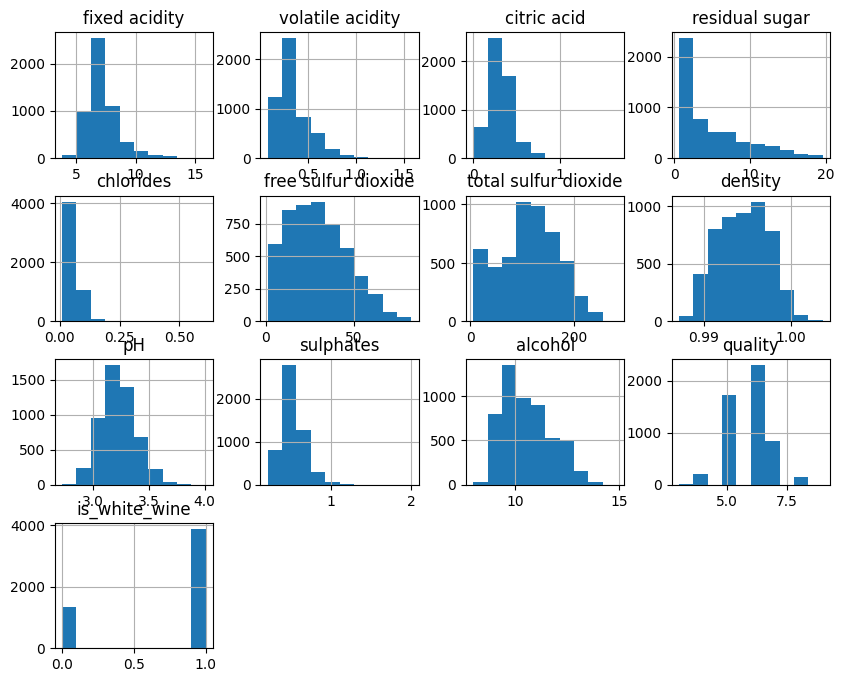

In [167]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
df.hist(ax = ax)
plt.title("Distributions before standardisation")
plt.show()

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_1619/2524330239.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.DataFrame(scaler.fit_transform(temp_df), columns=feats).hist(ax=ax)


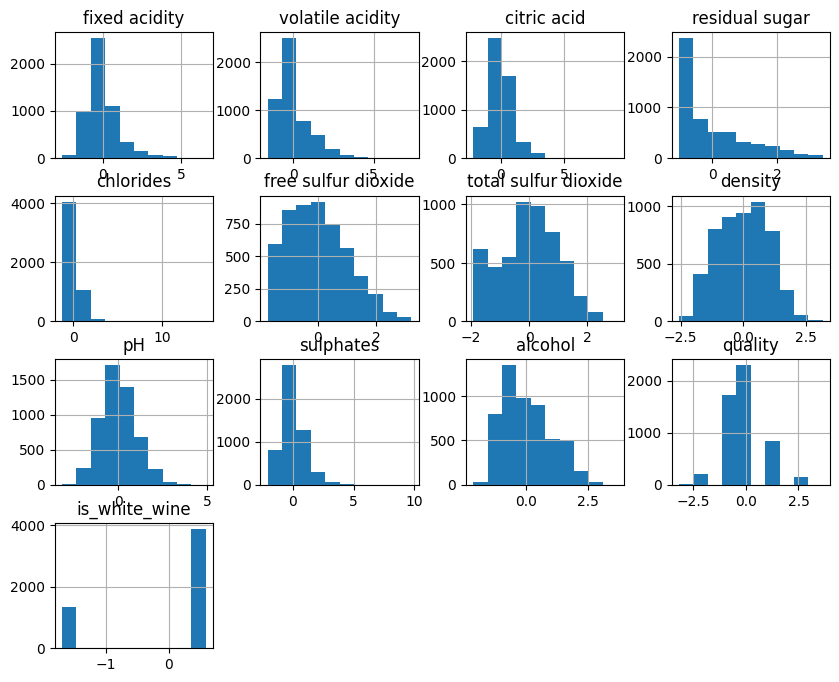

In [168]:
scaler = StandardScaler()

temp_df = df.drop("type", axis=1)

feats = temp_df.columns
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
pd.DataFrame(scaler.fit_transform(temp_df), columns=feats).hist(ax=ax)
plt.title("Distributions after standardisation")
plt.show()

## Normalising data

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_1619/4142698497.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax)


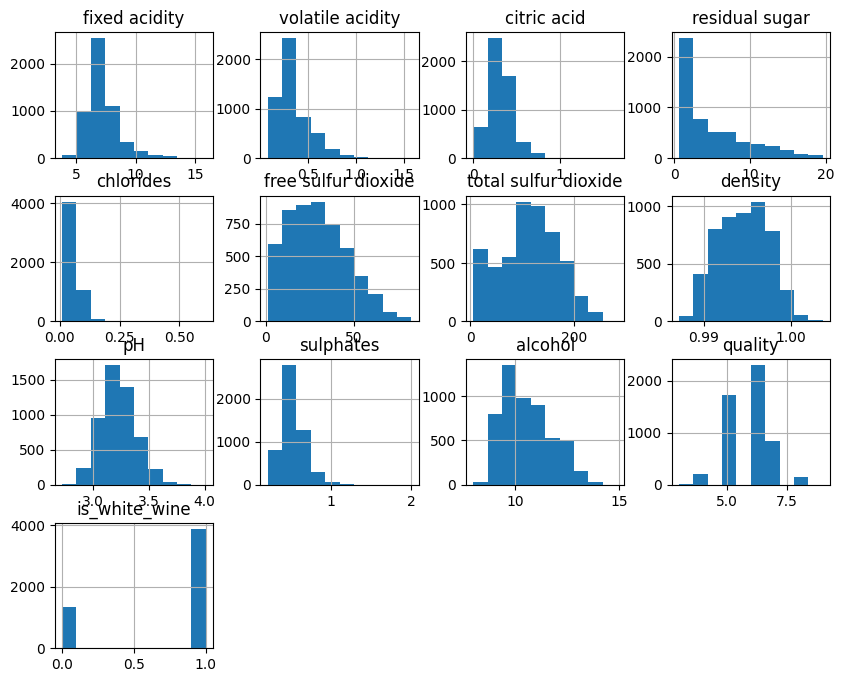

In [169]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
df.hist(ax = ax)
plt.title("Distributions before scaling")
plt.show()

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_1619/326388846.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.DataFrame(scaler.fit_transform(temp_df), columns=feats).hist(ax=ax)


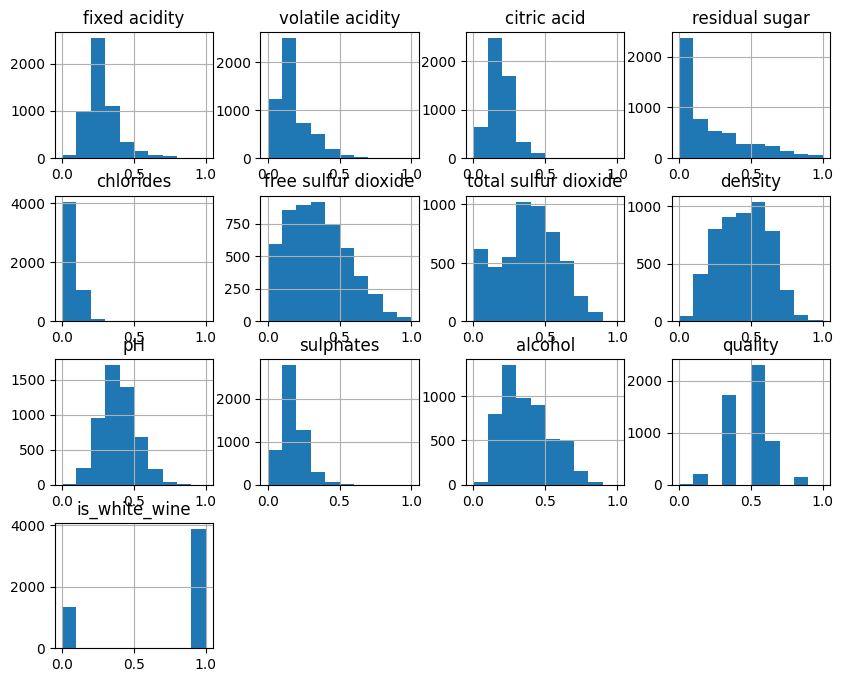

In [170]:
scaler = MinMaxScaler()

temp_df = df.drop("type", axis=1)

feats = temp_df.columns
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
pd.DataFrame(scaler.fit_transform(temp_df), columns=feats).hist(ax=ax)
plt.title("Distributions after scaling")
plt.show()

## Selecting features

In [171]:
features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
label = "is_white_wine"

## Extracting data

In [172]:
x = df[features]
y = df[label]

## Processing data

In [173]:
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

In [174]:
print(np.mean(y_train.values))
print(np.mean(y_test))

0.7421319796954314
0.7420091324200914


## Training model

In [175]:
lg = LogisticRegression()
lg.fit(x_train, y_train)

LogisticRegression()

## Predicting values and checking metrics

In [176]:
y_pred = lg.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))

Accuracy:  0.9969558599695586
F1 score:  0.9979508196721311


## Use F1 Score

![](https://www.google.com/url?sa=i&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FPrecision_and_recall&psig=AOvVaw3O9JE_7Yb3gIOjcZTZZxfh&ust=1669317997412000&source=images&cd=vfe&ved=0CBAQjRxqFwoTCMCo4KOExfsCFQAAAAAdAAAAABAE)

## Checking feature importance

In [177]:
perm = PermutationImportance(lg).fit(x_test, y_test)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.2426 ± 0.0181,density
0.1061 ± 0.0091,total sulfur dioxide
0.0651 ± 0.0068,residual sugar
0.0170 ± 0.0070,alcohol
0.0111 ± 0.0046,volatile acidity
0.0037 ± 0.0020,chlorides
0.0033 ± 0.0034,free sulfur dioxide
0.0021 ± 0.0026,sulphates
0 ± 0.0000,pH
-0.0003 ± 0.0007,fixed acidity


## Downsampling majority

In [178]:
red_wine_count = df[df[label] == 0].shape[0]
white_wine_count = df[df[label] == 1].shape[0]

white_wine_sample = df[df[label] == 1].sample(frac=1 - ((white_wine_count - red_wine_count) / white_wine_count))

balanced_df = pd.concat([white_wine_sample, df[df[label] == 0]])

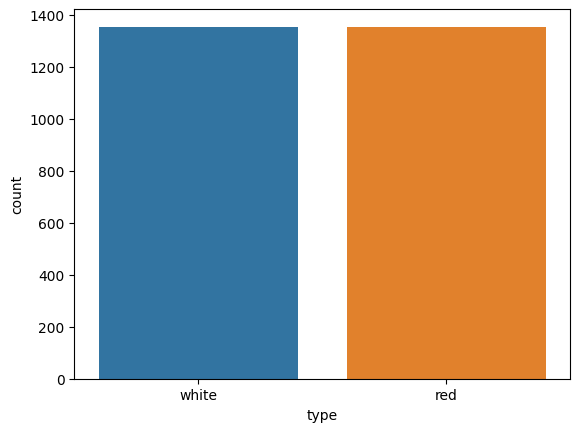

In [179]:
sns.countplot(x="type",data=balanced_df)
plt.show()

In [180]:
x = balanced_df[features]
y = balanced_df[label]

In [181]:
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

In [182]:
lg = LogisticRegression()
lg.fit(x_train, y_train)

LogisticRegression()

In [183]:
y_pred = lg.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))

Accuracy:  0.9926253687315634
F1 score:  0.9926362297496317


## Predcting quality of wine

In [184]:
features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "is_white_wine"]
label = "quality"

In [185]:
x = df[features]
y = df[label]

In [186]:
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

In [187]:
lg = LogisticRegression()
lg.fit(x_train, y_train)

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [189]:
y_pred = lg.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred, average="weighted"))

Accuracy:  0.5517503805175038
F1 score:  0.520287386750771


In [194]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.25      0.02      0.04        51
           5       0.60      0.61      0.61       433
           6       0.53      0.71      0.60       574
           7       0.54      0.25      0.34       212
           8       0.00      0.00      0.00        37
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1314
   macro avg       0.27      0.23      0.23      1314
weighted avg       0.53      0.55      0.52      1314



/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

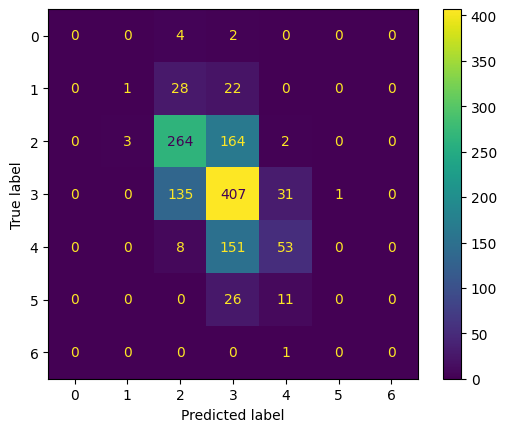

In [198]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

## Redefining problem

In [199]:
good_wine_threshold = 6
df["good_wine"] = df["quality"] > 6

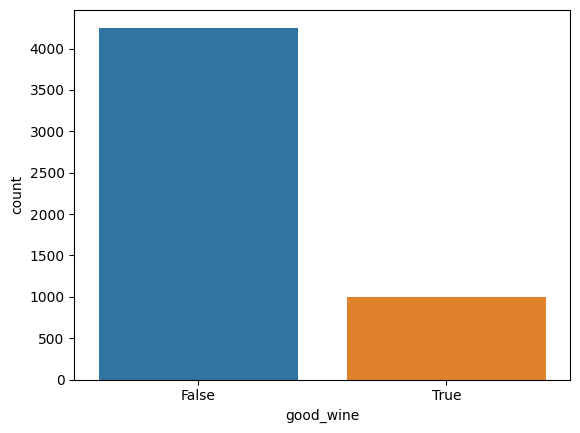

In [201]:
sns.countplot(x="good_wine",data=df)
plt.show()

In [202]:
features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "is_white_wine"]
label = "good_wine"

In [203]:
x = df[features]
y = df[label]

In [205]:
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

In [206]:
lg = LogisticRegression()
lg.fit(x_train, y_train)

LogisticRegression()

In [207]:
y_pred = lg.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))

Accuracy:  0.8135464231354642
F1 score:  0.3669250645994832


In [208]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.85      0.94      0.89      1064
        True       0.52      0.28      0.37       250

    accuracy                           0.81      1314
   macro avg       0.68      0.61      0.63      1314
weighted avg       0.79      0.81      0.79      1314



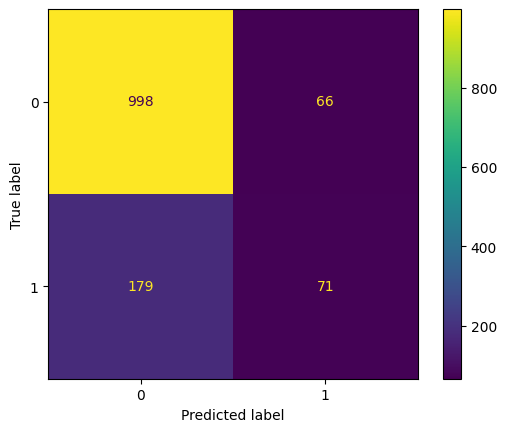

In [209]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [210]:
perm = PermutationImportance(lg).fit(x_test, y_test)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.0467 ± 0.0125,density
0.0269 ± 0.0064,residual sugar
0.0108 ± 0.0109,fixed acidity
0.0040 ± 0.0111,pH
0.0038 ± 0.0054,is_white_wine
0.0021 ± 0.0050,sulphates
0.0020 ± 0.0021,alcohol
-0.0002 ± 0.0055,chlorides
-0.0002 ± 0.0118,volatile acidity
-0.0009 ± 0.0042,total sulfur dioxide
